In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import ase
from ase.io import read,write
from ase.visualize import view
from glob import glob
from copy import copy
from tqdm import tqdm_notebook
import cPickle as pck

In [3]:
import sys,os
sys.path.insert(0,'../')

In [4]:
from ml_tools.descriptors import RawSoapInternal
from ml_tools.models import FullCovarianceTrainer,SoRTrainer
from ml_tools.utils import get_mae,get_rmse,get_sup,get_spearman,get_score,load_pck,dump_obj,load_obj
from ml_tools.split import KFold,LCSplit,ShuffleSplit
from ml_tools.model_selection import KRRFastCVScorer,CrossValidationScorer,GridSearch,LearningCurve
from ml_tools.compressor import FPSFilter


In [5]:
# filename of the molecular crystal structures
fn = './data/CSD500.xyz'
# atomic type for which to predict chemical shieldings
sp = 1
# atomic types present in the structures
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
# parameters for the soap descriptor
soap_params = dict(rc=4, nmax=8, lmax=6, awidth=0.4,
                   global_species=global_species,
                   nocenters=nocenters,
                   disable_pbar=True)

self_contribution = {1:0., 6:0., 7:0., 8:0.}

## utils

In [6]:
def get_sp_mapping(frames,sp):
    ii = 0
    fid2gids = {it:[] for it in range(len(frames))}
    for iframe,cc in enumerate(frames):
        for ss in cc.get_atomic_numbers():
            if ss == sp:
                fid2gids[iframe].append(ii)
                ii += 1
    return fid2gids

def extract_chemical_shielding(frames,sp):
    prop = []
    for cc in frames:
        numb = cc.get_atomic_numbers()
        prop.extend(cc.get_array('CS')[numb==sp])
    y = np.array(prop)
    return y

# train and predict

In [ ]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [ ]:
zeta = 2

representation = RawSoapInternal(**soap_params)

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)



In [9]:
X_train = representation.transform(frames_train)
trainer.precompute(y_train, X_train)

(650, 650) (650, 7168) (650, 7168)


In [10]:
model = trainer.fit(lambdas=[1e-2])

In [11]:
frames_test = read(fn,index='10:20')
y_test = extract_chemical_shielding(frames_test,sp)

In [12]:
y_pred = model.predict(frames_test)
get_score(y_pred,y_test)

(486, 650) (486, 7168) (650, 7168)


{'CORR': 0.8549624772823136,
 'MAE': 1.335958006886679,
 'R2': 0.7235301553149263,
 'RMSE': 1.9001659625937717,
 'SUP': 8.263027376724523}

# FPS selection of the samples

In [7]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [8]:
zeta = 2
Nselect = 10
representation = RawSoapInternal(**soap_params)

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)

kernel = trainer.kernel
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=False,disable_pbar=False)

In [9]:
rawsoaps = representation.transform(frames_train)

650
(650, 1)
(650,) 1.2915376058443324
(650,) 0


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdmcHMnLCBtYXg9NjQ5LCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXUnaW5pdGnigKY=


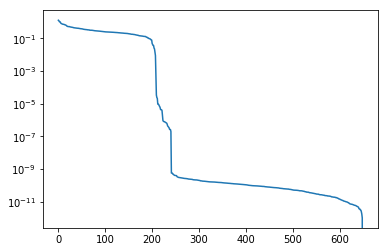

In [26]:
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [27]:
compressor.Nselect = 250
X = compressor.transform(rawsoaps)

# FPS selection of the features

In [8]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [15]:
KRRFastCVScorer?

In [9]:
zeta = 2
Nselect = 10
representation = RawSoapInternal(**soap_params)

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)

kernel = trainer.kernel
compressor = FPSFilter(Nselect,kernel,act_on='feature',precompute_kernel=False,disable_pbar=True)

In [10]:
rawsoaps = representation.transform(frames_train)

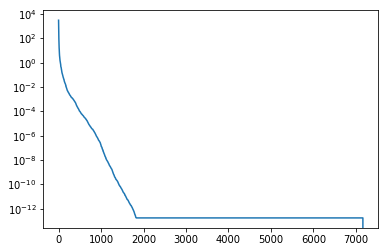

In [10]:
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [11]:
compressor.Nselect = 250
X = compressor.transform(rawsoaps)

# CV

In [7]:
frames_train = read(fn,index=':10')
y_train = extract_chemical_shielding(frames_train,sp)

In [8]:
zeta = 2
sigma = 1e-2

representation = RawSoapInternal(**soap_params)
trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)
cv = KFold(n_splits=6,random_state=10,shuffle=True)
scorer = KRRFastCVScorer([sigma],trainer,cv)

In [9]:
rawsoaps = representation.transform(frames_train)

In [10]:
scorer.fit(rawsoaps,y_train)

In [11]:
print scorer.get_summary(txt=True)

RMSE=1.545e-01 MAE=3.124e-02 R2=9.957e-01 CORR=9.969e-01 SUP=1.041e+00


In [12]:
trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)
cv = KFold(n_splits=6,random_state=10,shuffle=True)
scorer = CrossValidationScorer(trainer,cv,{'lambdas':[sigma]})

In [13]:
scorer.fit(rawsoaps,y_train)
print scorer.get_summary(txt=True)

RMSE=1.545e-01 MAE=3.124e-02 R2=9.957e-01 CORR=9.969e-01 SUP=1.040e+00


In [14]:
trainer = SoRTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)
cv = KFold(n_splits=6,random_state=10,shuffle=True)

In [38]:
X_pseudo = rawsoaps.extract_pseudo_input(np.arange(650))
scorer = CrossValidationScorer(trainer,cv,{'lambdas':[sigma],'X_pseudo':X_pseudo,'jitter':1e-6})

In [39]:
trainer.has_global_targets

False

In [40]:
scorer.fit(rawsoaps,y_train)
print scorer.get_summary(txt=True)

RMSE=1.545e-01 MAE=3.123e-02 R2=9.957e-01 CORR=9.969e-01 SUP=1.040e+00


# LC

In [7]:
frames_train = read(fn,index=':30')
y_train = extract_chemical_shielding(frames_train,sp)

In [8]:
zeta = 2
sigma = 1e-2

representation = RawSoapInternal(**soap_params)
trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power', has_global_targets=False,self_contribution=self_contribution,feature_transformations=representation)



In [10]:
rawsoaps = representation.transform(frames_train)

In [24]:
n_repeats=[5,5,5,5]
train_sizes=[5,10,15,20]
test_size=10
seed=10
model_params = {'lambdas':[sigma]}
lc = LearningCurve(trainer,model_params,n_repeats,train_sizes,test_size,seed)
lc.fit(rawsoaps,y_train)

Text(0.5,1,'Learning Curve')

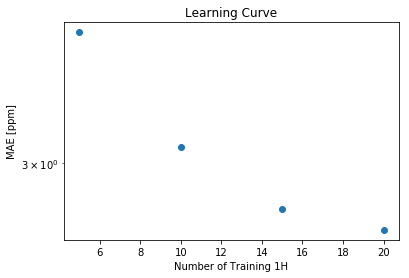

In [31]:
ax = lc.plot('MAE')
ax.set_ylabel('MAE [ppm]')
ax.set_xlabel('Number of Training 1H')
ax.set_title('Learning Curve')
